In [25]:
!pip install yfinance pandas pandas-ta

ERROR: Ignored the following versions that require a different python version: 0.4.67b0 Requires-Python >=3.12; 0.4.71b0 Requires-Python >=3.12
ERROR: Could not find a version that satisfies the requirement pandas-ta (from versions: none)
ERROR: No matching distribution found for pandas-ta


In [37]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from pathlib import Path
import numpy as np
import joblib
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean


In [ ]:
TOP_50_TICKERS = [
    "NVDA", "AAPL", "GOOG", "MSFT", "AMZN", "META", "TSLA", "AVGO", "2222.SR", "TSM",
    "BRK-B", "LLY", "WMT", "JPM", "TCEHY", "V", "ORCL", "MA", "005930.KS", "XOM",
    "JNJ", "PLTR", "BAC", "ASML", "ABBV", "NFLX", "601288.SS", "COST", "MC.PA", "BABA",
    "1398.HK", "AMD", "HD", "601939.SS", "ROG.SW", "PG", "GE", "MU", "CSCO", "KO",
    "WFC", "CVX", "UNH", "MS", "SAP", "TM", "AZN", "IBM", "CAT", "000660.KS"
]

current_dir = Path.cwd()
project_root = current_dir if current_dir.name != 'Notebooks' else current_dir.parent
raw_data_path = project_root / "Data" 
raw_data_path.mkdir(parents=True, exist_ok=True)

def fetch_tickers_in_batches(tickers, batch_size=10, period="6mo"):
    """Downloads tickers in small batches to prevent connection timeouts."""
    all_data = []
    
    for i in range(0, len(tickers), batch_size):
        batch = tickers[i:i + batch_size]
        print(f"Downloading batch: {batch}")
        
        # Download batch with auto_adjust as per report 
        data = yf.download(batch, period=period, group_by='ticker', auto_adjust=True, threads=True)
        
        if not data.empty:
            all_data.append(data)
        
        # Brief pause to respect API limits and server load
        time.sleep(1)
        
    return pd.concat(all_data, axis=1) if all_data else pd.DataFrame()

def robust_downloader(tickers, period="6mo", max_retries=3):
    print(f"Initiating resilient download for {len(tickers)} tickers...")
    
    # 1. Initial Batch Download
    df = fetch_tickers_in_batches(tickers, batch_size=15, period=period)
    
    # 2. Identify and Retry Failures
    for attempt in range(max_retries):
        existing_tickers = df.columns.get_level_values(0).unique()
        failed_tickers = [t for t in tickers if t not in existing_tickers or df[t].isnull().all().all()]
        
        if not failed_tickers:
            print("All tickers downloaded successfully.")
            break
            
        # Exponential backoff: sleep longer on each failure 
        wait_time = (attempt + 1) * 5
        print(f"Attempt {attempt + 1}/{max_retries}: {len(failed_tickers)} failures. Retrying in {wait_time}s...")
        time.sleep(wait_time)
        
        # Retry failures one by one for maximum stability
        for ticker in failed_tickers:
            try:
                retry_data = yf.download(ticker, period=period, auto_adjust=True)
                if not retry_data.empty:
                    # Align columns with multi-index structure
                    retry_data.columns = pd.MultiIndex.from_product([[ticker], retry_data.columns])
                    df = pd.concat([df, retry_data], axis=1)
            except Exception as e:
                print(f"Failed again for {ticker}: {e}")

    # 3. Quality Assurance: Automated Interpolation [cite: 384, 480]
    # This fills small gaps (holidays, glitches) ensuring indicator stability [cite: 386]
    df = df.sort_index().interpolate(method='time').ffill().bfill()
    
    # Final check
    missing_final = [t for t in tickers if t not in df.columns.get_level_values(0).unique()]
    if missing_final:
        print(f"CRITICAL: Data missing for {missing_final}")
    
    # Save the synchronized raw data [cite: 371]
    file_path = raw_data_path / "market_data_raw.csv"
    df.to_csv(file_path)
    print(f"Data ingestion complete. File saved: {file_path}")
    return df

# Run the updated downloader
raw_df = robust_downloader(TOP_50_TICKERS)

Initiating resilient download for 50 tickers...


[*********************100%***********************]  15 of 15 completed


[*********************100%***********************]  15 of 15 completed


[*********************100%***********************]  15 of 15 completed

1 Failed download:
['MU']: Timeout('Failed to perform, curl: (28) Connection timed out after 10002 milliseconds. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


[*********************100%***********************]  5 of 5 completed


Attempt 1/3: 1 failures. Retrying in 5s...


[*********************100%***********************]  1 of 1 completed


Failed again for MU: isna is not defined for MultiIndex
Attempt 2/3: 1 failures. Retrying in 10s...


[*********************100%***********************]  1 of 1 completed


Failed again for MU: isna is not defined for MultiIndex
Attempt 3/3: 1 failures. Retrying in 15s...


[*********************100%***********************]  1 of 1 completed

Failed again for MU: isna is not defined for MultiIndex
Data ingestion complete. File saved: b:\VSCode\Projects\Stock-Market-Trend-Analysis\Data\market_data_raw.csv


In [6]:
# Feature engineering 
current_dir = Path.cwd()
project_root = current_dir if current_dir.name != 'Notebooks' else current_dir.parent
raw_file = project_root / "Data" / "market_data_raw.csv"
proc_dir = project_root / "Data" 
proc_dir.mkdir(parents=True, exist_ok=True)

def calculate_indicators(df):
    """Manually calculates the Top 5 indicators from Appendix 11.1"""
    # Rank 1: RSI_14 (Momentum) [cite: 513]
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI_14'] = 100 - (100 / (1 + rs))

    # Rank 2: SMA Ratio 5/20 (Trend) [cite: 513]
    df['SMA_5'] = df['Close'].rolling(window=5).mean()
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_Ratio_5_20'] = df['SMA_5'] / df['SMA_20']

    # Rank 3: MACD Histogram (Trend) [cite: 513]
    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema12 - ema26
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal']

    # Rank 4: Bollinger Bands Position (Volatility) [cite: 513]
    std = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['SMA_20'] + (std * 2)
    df['BB_Lower'] = df['SMA_20'] - (std * 2)
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])

    # Rank 5: Volume Ratio to 20-day SMA (Volume) [cite: 513]
    df['Vol_SMA_20'] = df['Volume'].rolling(window=20).mean()
    df['Volume_Ratio'] = df['Volume'] / df['Vol_SMA_20']

    return df.dropna()

print("Loading raw data and calculating features...")
df_raw = pd.read_csv(raw_file, header=[0, 1], index_col=0, parse_dates=True)
tickers = df_raw.columns.get_level_values(0).unique()

all_processed = []
for ticker in tickers:
    try:
        stock_data = df_raw[ticker].copy()
        if stock_data.empty or len(stock_data) < 50:
            continue 

        processed_stock = calculate_indicators(stock_data)
        processed_stock.loc[:, 'Ticker'] = ticker
        all_processed.append(processed_stock)
    except Exception as e:
        print(f"Skipping {ticker}: Not enough valid data found.")

final_df = pd.concat(all_processed)
final_df.to_csv(proc_dir / "market_data_features.csv")

print(f"Success! Day 3 complete. Features saved for {len(all_processed)} tickers.")
print(f"Processed file location: {proc_dir / 'market_data_features.csv'}")

Loading raw data and calculating features...


C:\Users\prana\AppData\Local\Temp\ipykernel_9172\3866986195.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_stock.loc[:, 'Ticker'] = ticker
C:\Users\prana\AppData\Local\Temp\ipykernel_9172\3866986195.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_stock.loc[:, 'Ticker'] = ticker
C:\Users\prana\AppData\Local\Temp\ipykernel_9172\3866986195.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Skipping MU: Not enough valid data found.


C:\Users\prana\AppData\Local\Temp\ipykernel_9172\3866986195.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_stock.loc[:, 'Ticker'] = ticker
C:\Users\prana\AppData\Local\Temp\ipykernel_9172\3866986195.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_stock.loc[:, 'Ticker'] = ticker
C:\Users\prana\AppData\Local\Temp\ipykernel_9172\3866986195.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Success! Day 3 complete. Features saved for 49 tickers.
Processed file location: b:\VSCode\Projects\Stock-Market-Trend-Analysis\Data\market_data_features.csv


In [7]:
# Anomaly Detection (Isolation Forest)
csv_path=proc_dir / "market_data_features.csv"
anomaly_df=pd.read_csv(csv_path)
features =[
    'RSI_14',
    'SMA_5',
    'SMA_20',
    'SMA_Ratio_5_20',
    'MACD_Histogram',
    'BB_Position',
    'Volume_Ratio'
    ]
iso_model = IsolationForest(n_estimators=100, max_samples ='auto', contamination = 0.05, random_state =42, max_features=len(features), n_jobs=-1)
results=[]
for ticker in anomaly_df['Ticker'].unique():
    ticker_subset=anomaly_df[anomaly_df['Ticker']==ticker].copy()
    if len(ticker_subset)>50:
        X_ticker=ticker_subset[features].dropna()
        ticker_subset['Anomaly_Flag'] = iso_model.fit_predict(X_ticker)
        ticker_subset['Is_Anomaly'] = ticker_subset['Anomaly_Flag'].apply(lambda x: 1 if x == -1 else 0)
        results.append(ticker_subset)

final_anomaly_df = pd.concat(results)
final_anomaly_df.to_csv(proc_dir / "market_data_anomalies.csv", index=False)

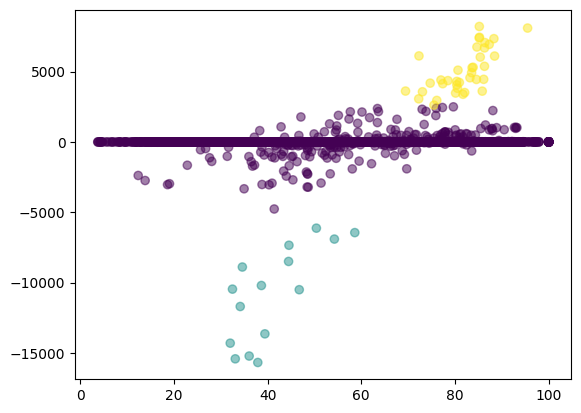

In [27]:
# Behavioral Clustering (K-means)
clustering_df=pd.read_csv(proc_dir / "market_data_features.csv")
features =[
    'RSI_14',
    'MACD_Histogram',
    'BB_Position',
    'SMA_Ratio_5_20',
    'Volume_Ratio',
]
kmeans_model=KMeans(n_clusters=3, random_state=42, n_init='auto')
scaler=RobustScaler()
results=[]
scaled=scaler.fit_transform(clustering_df[features].dropna())
clustering_df.loc[clustering_df[features].dropna().index, 'Cluster_Label'] = kmeans_model.fit_predict(scaled)
results.append(clustering_df)
final_clustering_df = pd.concat(results)
final_clustering_df.to_csv(proc_dir / "market_data_clusters.csv", index=False)
plt.scatter(final_clustering_df['RSI_14'], final_clustering_df['MACD_Histogram'], c=final_clustering_df['Cluster_Label'], cmap='viridis', alpha=0.5)


In [ ]:
#K-Means Model

clustering_df=pd.read_csv(proc_dir / "market_data_features.csv")
model_root=project_root / "Models"
model_root.mkdir(parents=True, exist_ok=True)
features=[
    'RSI_14',
    'MACD_Histogram', 
    'BB_Position', 
    'SMA_Ratio_5_20', 
    'Volume_Ratio'
    ]

scaler =StandardScaler()
X_scaled=scaler.fit_transform(clustering_df[features].dropna())

inertias=[]
silhouette_scores=[]
k_range=range(3,11)

for k in k_range:
    kmeans_model=KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_model.fit(X_scaled)
    inertias.append(kmeans_model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_model.labels_))

optimal_k=5
kmeans=KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clustering_df['Cluster']=kmeans.fit_predict(X_scaled)

joblib.dump(kmeans, model_root / "kmeans_model.pkl")
clustering_df.to_csv(proc_dir / "market_data_clusters.csv", index=False)


def find_similar_tickers(query_ticker_features, df, kmeans, scaler, top_n=5):
    query_df = pd.DataFrame([query_ticker_features])
    query_scaled = scaler.transform(query_df[features])
    
    query_cluster = kmeans.predict(query_scaled)[0]
    
    cluster_tickers = df[df['Cluster'] == query_cluster].copy()
    
    distances = []
    for idx, row in cluster_tickers.iterrows():
        ticker_features = row[features].values.reshape(1, -1)
        ticker_scaled = scaler.transform(ticker_features)
        dist = euclidean(query_scaled[0], ticker_scaled[0])
        distances.append(dist)
    
    cluster_tickers['Distance'] = distances
    
    similar_tickers = cluster_tickers.nsmallest(top_n, 'Distance')
    
    return similar_tickers[['Ticker', 'Distance', 'Cluster'] + features]

query_features = {
    'RSI_14': 65.5,
    'SMA_Ratio_5_20': 1.02,
    'MACD_Histogram': 0.5,
    'BB_Position': 0.7,
    'Volume_Ratio': 1.3
}

similar = find_similar_tickers(query_features, clustering_df, kmeans, scaler, top_n=3)
print(similar)

C:\Users\prana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\prana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\prana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\prana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-pac

     Ticker  Distance  Cluster  ...  BB_Position  SMA_Ratio_5_20  Volume_Ratio
509   TCEHY  0.190067        1  ...     0.658677        1.022795      1.260776
457   TCEHY  0.215252        1  ...     0.695057        1.022255      1.386354
2761    BAC  0.245912        1  ...     0.663375        1.014186      1.322884

[3 rows x 8 columns]
